In [72]:
import sys
import argparse
import csv
import math
import aubio
import numpy as np
import matplotlib.pyplot as plt

In [126]:
name = "slovak"
filename = "../samples/%s.wav" % name

In [127]:
SAMPLE_RATE = 44100
WINDOW_SIZE = 4096 # fft size
HOP_SIZE = 1024
TOLERANCE = 0.8
METHOD = 'yinfft'

### Target Frequencies
The score, the clarinet runs from the G below Middle C to the C two octactives about. Because a clarinet is tuned to Bb, this is transposed down to F to Bb. In [modern tuning](https://en.wikipedia.org/wiki/Piano_key_frequencies), that's F3 (key #33) to Bb5 (key #62) on a piano, which is easy to calculate:

In [128]:
def getPianoFrequency(key_number):
    return np.power(2, (key_number-49) / 12) * 440

In [129]:
F3 = getPianoFrequency(33)
Bb5 = getPianoFrequency(62)
intermediateNotes = [ getPianoFrequency(f) for f in range(34,62) ]

In [130]:
pitches = []
s = aubio.source(filename, SAMPLE_RATE, HOP_SIZE)
pitch_o = aubio.pitch(METHOD, WINDOW_SIZE, HOP_SIZE, SAMPLE_RATE)
pitch_o.set_unit("Hz")
pitch_o.set_tolerance(TOLERANCE)
total_frames = 0
while True:
    samples, read = s()
    pitch = pitch_o(samples)[0]
    pitches += [pitch]
    total_frames += read
    if read < HOP_SIZE: 
        print("read %s frames with method %s" % (total_frames, METHOD))
        break
        
# sometimes the first few pitches are off the charts        
while abs(pitches[0] - F3) > 50:
    pitches.pop(0)

read 149924 frames with method yinfft


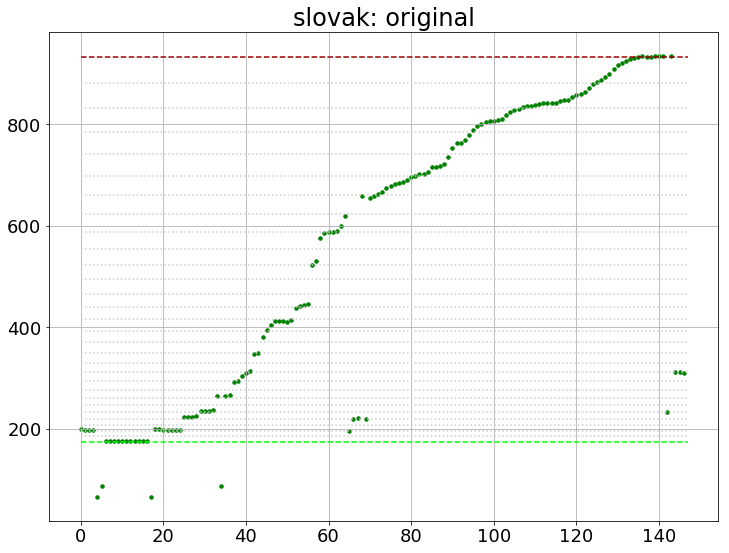

In [131]:
def plotFrequencies(pitch_group, name, chartName, write=False):
    #pitch_group = np.array(pitch_group)
    fig = plt.figure(figsize=(12, 9), frameon=True)
    plt.title(name + ": " + chartName, fontsize=24)
    plt.hlines([F3, Bb5], xmin=0, xmax=len(pitch_group), linestyles="dashed", colors=["#00FF00", "#990000"])
    plt.hlines(intermediateNotes, xmin=0, xmax=len(pitch_group), linestyles="dotted", colors="#CCCCCC")
    ax = fig.gca()
    ax.tick_params(labelsize=18)
    
    for (i,c) in enumerate(pitch_group):
        if type(c) == tuple:
            ax.scatter(i,c[0], color=c[1], s=12)
        else:
            ax.scatter(i,c, color="green", s=12)    
            
    #ax.plot(list(range(len(pitch_group))), pitch_group, '.g', color="green")
    plt.grid()
    plt.show()
    if write:
        image_path = "../output/images/%s_%s.png" % (name, chartName)
        fig.savefig(image_path, pad_inches=1, dpi=300)
        
plotFrequencies(pitches, name, "original", True)

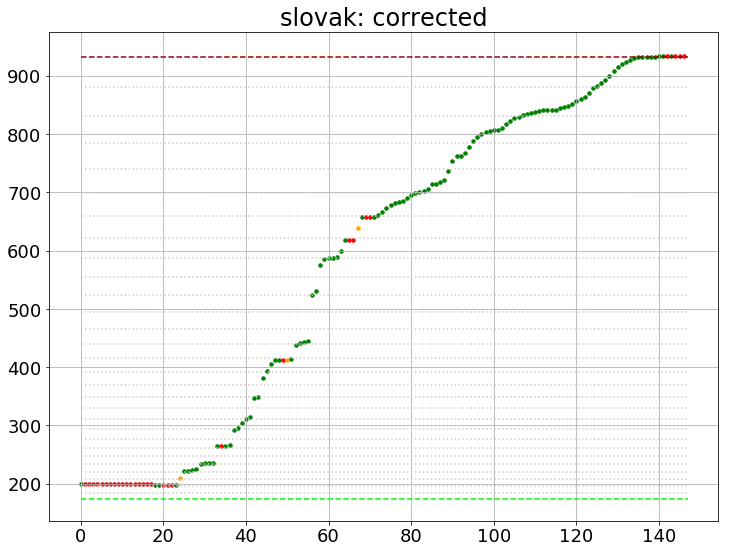

In [132]:
# identify all the outliers and move into the always-rising range

THRESHOLD = 0.001

corrected = [ ( pitch, "green" ) for pitch in pitches ]

for i in range(1, len(corrected)):
    current = corrected[i][0]
    previous = corrected[i-1][0]
    diff = (previous - current) / previous
    
    if diff > THRESHOLD:
        if (i < len(corrected) - 1 and (corrected[i+1][0] - previous) / previous > THRESHOLD):
            average = (previous + corrected[i+1][0]) / 2
            #print("averaging", i, current, corrected[i+1][0], previous, diff, average)
            corrected[i] = ( average, "orange" )
        else:
            #print('moving up note at %s from %s to %s (%s)' % (i, current, previous, diff))                
            corrected[i] = ( previous, "red" )
            
plotFrequencies(corrected, name, "corrected", True)

In [133]:
data_path = "../output/data/%s.csv" % name

with open(data_path, "w") as csvfile:
    spamwriter = csv.writer(csvfile)
    spamwriter.writerow(["freq"])    
    spamwriter.writerows(map(lambda x: [x], smoothed))